# Crisis Text Line homework assignment for Senior Data Scientist position
Tiffany Meshkat

### I chose to analyze the Astronomy Stack Exchange data (astronomy.stackexchange.com)


In [1]:
###Import standard libraries
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk

In [2]:
###learned about the data columns from
# https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

In [3]:
###Import this library to read in the xml file
import xml.etree.ElementTree as ET

directory='./data_astronomy/'

tree=ET.parse(directory+'Posts.xml')
root=tree.getroot()

In [4]:
root.tag

'posts'

In [5]:
###Look at the first entry
root[0].attrib

{'Id': '1',
 'PostTypeId': '1',
 'AcceptedAnswerId': '879',
 'CreationDate': '2013-09-24T18:51:54.593',
 'Score': '34',
 'ViewCount': '1084',
 'Body': '<p>Suppose I would like to calculate the inclination of a satellite from the <strong>ecliptic</strong>. Would it be possible to do this with an amateur telescope? How would I go about doing so?</p>\n\n<hr>\n\n<p>Note: A good answer should tell what kind of telescope an amateur would need, what measurements they would need to make, then what calculations they would have to perform to get the inclination (or the "instantaneous angular measurement from the ecliptic at the time of measurement").</p>\n',
 'OwnerUserId': '6',
 'LastEditorUserId': '6',
 'LastEditDate': '2013-11-01T11:23:02.907',
 'LastActivityDate': '2014-02-03T16:49:55.200',
 'Title': 'How do I calculate the inclination of an object with an amateur telescope?',
 'Tags': '<inclination><amateur-observing>',
 'AnswerCount': '2',
 'CommentCount': '0',
 'FavoriteCount': '3',
 'Con

In [6]:
##Convert the full xml file to a dataframe for easier use.
Id=[]
PostTypeId=[]
AcceptedAnswerId=[]
ParentId=[]
CreationDate=[]
Score=[]
ViewCount=[]
Body=[]
OwnerUserId=[]
LastEditorDisplayName=[]
LastEditDate=[]
LastActivityDate=[]
Title=[]
Tags=[]
AnswerCount=[]
CommentCount=[]
FavoriteCount=[]

###create a function to check if the column exists, otherwise replace with 0
def col_exists(child,column_name):
    try:
        return child.attrib[column_name]
    except:
        return 0

for child in root:
    
    Id.append(col_exists(child,'Id'))
    PostTypeId.append(col_exists(child,'PostTypeId'))
    AcceptedAnswerId.append(col_exists(child,'AcceptedAnswerId'))
    ParentId.append(col_exists(child,'ParentId'))
    CreationDate.append(col_exists(child,'CreationDate'))
    Score.append(col_exists(child,'Score'))
    ViewCount.append(col_exists(child,'ViewCount'))
    Body.append(col_exists(child,'Body'))
    LastEditDate.append(col_exists(child,'LastEditDate'))
    LastActivityDate.append(col_exists(child,'LastActivityDate'))
    Title.append(col_exists(child,'Title'))
    Tags.append(col_exists(child,'Tags'))
    AnswerCount.append(col_exists(child,'AnswerCount'))
    CommentCount.append(col_exists(child,'CommentCount'))
    FavoriteCount.append(col_exists(child,'FavoriteCount'))

In [7]:
df=pd.DataFrame({'Id':Id, 'PostTypeId':PostTypeId,'AcceptedAnswerId':AcceptedAnswerId,'ParentId':ParentId,
                      'CreationDate':CreationDate,'Score':Score, 'ViewCount':ViewCount,'Body':Body,
                      'LastEditDate':LastEditDate, 'LastActivityDate':LastActivityDate, 'Title':Title,
                      'Tags':Tags,'AnswerCount':AnswerCount,'CommentCount':CommentCount,
                     'FavoriteCount':FavoriteCount})

In [8]:
##Look at the first few rows of the data, it includes many columns like creation date and the body of the text
df.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,Score,ViewCount,Body,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,1,1,879,0,2013-09-24T18:51:54.593,34,1084,<p>Suppose I would like to calculate the incli...,2013-11-01T11:23:02.907,2014-02-03T16:49:55.200,How do I calculate the inclination of an objec...,<inclination><amateur-observing>,2,0,3
1,2,1,45,0,2013-09-24T18:53:25.647,24,258,<p>How are exoplanetary atmosphere composition...,0,2020-12-04T17:02:08.540,How are the compositional components of exopla...,<exoplanet><atmosphere>,1,1,0
2,3,1,0,0,2013-09-24T18:54:53.473,28,928,"<p>Are there any easily resolvable, binary sta...",2013-09-24T19:00:42.437,2014-01-14T15:45:53.260,Amateur observing targets for binary star syst...,<amateur-observing><binary-star>,2,6,0
3,4,1,5,0,2013-09-24T18:57:01.680,27,21942,"<p>Sunspots, such as this one, appear dark:</p...",2020-06-02T10:41:14.250,2020-06-05T11:23:56.290,Why do sunspots appear dark?,<the-sun><sunspots>,2,5,2
4,5,2,0,4,2013-09-24T18:57:01.680,26,0,<p>Typical sunspots have a dark region (umbra)...,2017-03-10T09:42:46.850,2016-08-25T13:40:02.363,0,0,0,3,0


In [9]:
##Look at the shape of the data, how many rows,columns are there?
df.shape


(26071, 15)

In [10]:
##This text is pretty messy, so lets clean this up.
df['Body'][4]

'<p>Typical sunspots have a dark region (umbra) surrounded by a lighter region, the penumbra. While sunspots have a temperature of about 6300 °F (3482.2 °C), the surface of the sun which surrounds it has a temperature of 10,000 °F (5537.8 °C).</p>\n\n<p>From <a href="https://image.gsfc.nasa.gov/poetry/workbook/sunspot.html" rel="noreferrer">this NASA resource</a>:</p>\n\n<blockquote>\n  <p>Sunspots are actually regions of the solar surface where the magnetic field of the Sun becomes concentrated over 1000-fold. Scientists do not yet know how this happens. Magnetic fields produce pressure, and this pressure can cause gas inside the sunspot to be in balance with the gas outside the sunspot...but at a lower temperature. Sunspots are actually several thousand degrees cooler than the 5,770 K (5496.8 °C) surface of the Sun, and contain gases at temperature of 3000 to 4000 K (2726.9 - 3726.8 °C). They are dark only by contrast with the much hotter solar surface. <strong>If you were to put a s

In [11]:
###Remove URLs and html tags (not 100% effective at removing all urls)
cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
cleantext=re.sub(cleanr, '', df['Body'][4])
##Still has some carriage return \n and slashes s so lets remove those too
cleanr2 = re.compile('\n|\\\\|\'')
cleantext=re.sub(cleanr2,'',cleantext)

In [12]:
#Lets replace the body column with the cleaned text
for i,body in enumerate(df['Body']):
    cleantext1=re.sub(cleanr, '', body)
    cleantext2=re.sub(cleanr2,'',cleantext1)
    df['Body'][i]=cleantext2

In [13]:
df['Body'][4]

'Typical sunspots have a dark region (umbra) surrounded by a lighter region, the penumbra. While sunspots have a temperature of about 6300 °F (3482.2 °C), the surface of the sun which surrounds it has a temperature of 10,000 °F (5537.8 °C).From this NASA resource:  Sunspots are actually regions of the solar surface where the magnetic field of the Sun becomes concentrated over 1000-fold. Scientists do not yet know how this happens. Magnetic fields produce pressure, and this pressure can cause gas inside the sunspot to be in balance with the gas outside the sunspot...but at a lower temperature. Sunspots are actually several thousand degrees cooler than the 5,770 K (5496.8 °C) surface of the Sun, and contain gases at temperature of 3000 to 4000 K (2726.9 - 3726.8 °C). They are dark only by contrast with the much hotter solar surface. If you were to put a sunspot in the night sky, it would glow brighter than the Full Moon with a crimson-orange color!Sunspots are areas of intense magentic a

In [14]:
###Looks better now!

## 1a. Who is represented in the dataset?
This dataset includes 26071 posts, 10490 of which are questions. The people represented here are anyone who asked or answered a question on the astronomy.stackexschange.com website.

In [15]:
##Column headers
df.dtypes

Id                  object
PostTypeId          object
AcceptedAnswerId    object
ParentId            object
CreationDate        object
Score               object
ViewCount           object
Body                object
LastEditDate        object
LastActivityDate    object
Title               object
Tags                object
AnswerCount         object
CommentCount        object
FavoriteCount       object
dtype: object

In [16]:
##Check for Nans

df.isnull().sum()

Id                  0
PostTypeId          0
AcceptedAnswerId    0
ParentId            0
CreationDate        0
Score               0
ViewCount           0
Body                0
LastEditDate        0
LastActivityDate    0
Title               0
Tags                0
AnswerCount         0
CommentCount        0
FavoriteCount       0
dtype: int64

In [17]:
##look at one example Tag
df['Tags'][0]

'<inclination><amateur-observing>'

## 1b. What are some frequently occurring topics?

In [18]:
##1b. What are some frequenly occurring topics?
##Look for the most common words

In [19]:
###Have a look at the categories:

In [20]:
df['Tags'].value_counts()[0:10]

0                            15581
<star>                         111
<telescope>                    107
<black-hole>                    98
<the-moon>                      89
<the-sun>                       72
<universe>                      61
<orbit>                         59
<observational-astronomy>       56
<galaxy>                        49
Name: Tags, dtype: int64

In [21]:
##These tags include multiple words. Lets sort through to find the most requently occurring words
##First of all add in more stop words to catch and remove common words like "the"
nlp = spacy.load('en_core_web_lg')
for word in STOP_WORDS:
    for w in (word, word[0].capitalize(), word.upper()):
        lex = nlp.vocab[w]
        lex.is_stop = True


In [22]:
##Remove the nonalphanumerics and stop words
##Create a list of the tokens from the Tags column

def tokens_list(a_df,column):
    tokens=[]
    remove=re.compile('[^A-Za-z]+')

    for row in a_df[column]:
        if row!=0:
            ##Create a Spacy NLP document for the Tags column, also remove the non alpha characters
            doc=nlp( remove.sub(' ',row.lower()) )

            ##Find just the tokens (ignore the spaces)
            tokens_this_row=[token.text for token in doc if token.is_alpha and not token.is_stop]

            tokens+=tokens_this_row
        else:
            continue
    return tokens

In [23]:
### Create a list of tokens from the Tags column
tag_tokens=tokens_list(df,'Tags')

In [24]:
### What are the most common words in the Tags column?
Counter(tag_tokens).most_common(10)

[('star', 1528),
 ('astronomy', 1235),
 ('telescope', 937),
 ('black', 776),
 ('hole', 769),
 ('solar', 753),
 ('planet', 743),
 ('observational', 742),
 ('sun', 696),
 ('galaxy', 690)]

In [25]:
###The most common topics are star, astronomy, telescope, black hole, solar, planet, observational, sun, galaxy
###Also consider the value counts above, for the combined tags

## 1c. What are the most viewed topics?

In [26]:
##Cast the viewcounts as integers
df['ViewCount']=df['ViewCount'].astype(int)

In [27]:
###Find the posts with the highest view counts and find the tags/topics

###Pick out just those which have the highest 50 view counts, lets find the topics of these
df.sort_values(by=['ViewCount'],ascending=False)[0:50]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,Score,ViewCount,Body,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
5772,11634,1,11938,0,2015-08-25T00:56:27.563,8,228798,"I was camping this weekend away from the city,...",2017-07-16T18:17:47.397,2017-10-30T13:22:46.647,"Star like light moving in the sky, what could ...",<star><light>,3,14,9
4233,8788,1,8797,0,2015-02-06T07:09:00.500,24,139563,I have a 3inch Newtonian reflector telescope w...,2020-10-14T15:44:43.073,2020-10-14T15:44:43.073,How much magnification is needed to see the pl...,<solar-system><telescope><amateur-observing>,2,0,7
642,703,1,0,0,2013-10-18T23:36:34.833,7,99965,From some time now (few weeks as far as I can ...,2014-11-24T19:27:00.247,2016-12-15T17:53:56.627,Very bright star in the east at northern hemis...,<star>,6,4,2
13207,23320,1,23323,0,2017-10-27T18:01:20.393,8,92288,"Last night, I was on my balcony at 1AM (PST) a...",2017-10-28T08:13:18.270,2019-05-02T08:06:59.223,"What is this rapidly twinkling red, blue, and ...",<star><night-sky>,4,5,1
6779,12824,1,12826,0,2015-12-10T13:48:33.520,15,91421,From the time that the sun appears on the hori...,0,2018-07-02T03:24:43.453,How long does a sunrise or sunset take?,<the-sun>,4,2,1
12470,22061,1,0,0,2017-08-11T13:57:05.490,5,77753,I keep hearing that you can go blind during a ...,2017-08-17T16:58:38.680,2017-08-21T04:28:38.590,Is the sun any brighter during a solar eclipse,<solar-eclipse>,2,2,0
18728,32034,1,0,0,2019-05-24T23:11:32.033,13,72231,My husband and I have just seen a line of abou...,2019-06-10T09:46:54.533,2019-06-10T10:20:06.707,"Line of lights moving in a straight line, with...",<satellite><identify-this-object>,1,2,4
5658,11505,1,11506,0,2015-08-09T00:30:00.690,17,68215,I thought dark and anti matter were kinda the ...,0,2016-01-28T14:21:48.973,"What are the differences between matter, dark ...",<dark-matter><matter><antimatter>,2,1,6
3588,8042,1,8044,0,2014-11-24T04:18:42.303,6,60388,How to define moonless night? There is no moon...,0,2018-01-04T01:51:13.253,moonless night and lunar phase,<the-moon>,1,4,0
7711,13948,1,13950,0,2016-03-01T08:37:28.297,12,60095,There will be a solar eclipse soon at my area....,2016-03-02T04:57:03.940,2017-08-15T01:03:17.927,Is it safe to watch solar eclipse's reflection...,<solar-eclipse>,1,3,3


In [28]:
###Create a dataframe of just the highest view counts
df_viewcount=df.sort_values(by=['ViewCount'],ascending=False)[0:50]

In [29]:
tag_tokens_viewcount=tokens_list(df_viewcount,'Tags')

In [30]:
df_viewcount

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,Score,ViewCount,Body,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
5772,11634,1,11938,0,2015-08-25T00:56:27.563,8,228798,"I was camping this weekend away from the city,...",2017-07-16T18:17:47.397,2017-10-30T13:22:46.647,"Star like light moving in the sky, what could ...",<star><light>,3,14,9
4233,8788,1,8797,0,2015-02-06T07:09:00.500,24,139563,I have a 3inch Newtonian reflector telescope w...,2020-10-14T15:44:43.073,2020-10-14T15:44:43.073,How much magnification is needed to see the pl...,<solar-system><telescope><amateur-observing>,2,0,7
642,703,1,0,0,2013-10-18T23:36:34.833,7,99965,From some time now (few weeks as far as I can ...,2014-11-24T19:27:00.247,2016-12-15T17:53:56.627,Very bright star in the east at northern hemis...,<star>,6,4,2
13207,23320,1,23323,0,2017-10-27T18:01:20.393,8,92288,"Last night, I was on my balcony at 1AM (PST) a...",2017-10-28T08:13:18.270,2019-05-02T08:06:59.223,"What is this rapidly twinkling red, blue, and ...",<star><night-sky>,4,5,1
6779,12824,1,12826,0,2015-12-10T13:48:33.520,15,91421,From the time that the sun appears on the hori...,0,2018-07-02T03:24:43.453,How long does a sunrise or sunset take?,<the-sun>,4,2,1
12470,22061,1,0,0,2017-08-11T13:57:05.490,5,77753,I keep hearing that you can go blind during a ...,2017-08-17T16:58:38.680,2017-08-21T04:28:38.590,Is the sun any brighter during a solar eclipse,<solar-eclipse>,2,2,0
18728,32034,1,0,0,2019-05-24T23:11:32.033,13,72231,My husband and I have just seen a line of abou...,2019-06-10T09:46:54.533,2019-06-10T10:20:06.707,"Line of lights moving in a straight line, with...",<satellite><identify-this-object>,1,2,4
5658,11505,1,11506,0,2015-08-09T00:30:00.690,17,68215,I thought dark and anti matter were kinda the ...,0,2016-01-28T14:21:48.973,"What are the differences between matter, dark ...",<dark-matter><matter><antimatter>,2,1,6
3588,8042,1,8044,0,2014-11-24T04:18:42.303,6,60388,How to define moonless night? There is no moon...,0,2018-01-04T01:51:13.253,moonless night and lunar phase,<the-moon>,1,4,0
7711,13948,1,13950,0,2016-03-01T08:37:28.297,12,60095,There will be a solar eclipse soon at my area....,2016-03-02T04:57:03.940,2017-08-15T01:03:17.927,Is it safe to watch solar eclipse's reflection...,<solar-eclipse>,1,3,3


In [31]:
#### These are the most common tokens
Counter(tag_tokens_viewcount).most_common(10)


[('star', 11),
 ('sun', 9),
 ('solar', 8),
 ('telescope', 8),
 ('moon', 7),
 ('earth', 6),
 ('amateur', 5),
 ('observing', 5),
 ('eclipse', 5),
 ('system', 4)]

In [32]:
## Here are the most common tags
df_viewcount['Tags'].value_counts()[0:10]

<the-moon>                                                     2
<telescope>                                                    2
<solar-eclipse>                                                2
<star>                                                         2
<the-sun>                                                      2
<telescope><optics><refractor-telescope><telescope-making>     1
<observational-astronomy><amateur-observing><solar-eclipse>    1
<the-sun><constellations>                                      1
<solar-system><telescope><amateur-observing>                   1
<the-moon><orbit><earth><distances>                            1
Name: Tags, dtype: int64

## 1d. What time of year do people ask the most questions?


In [33]:
###Now want to look at the subset of the dataframe which are the original questions (not answers or comments)
###And see what time of year most people ask questions, lets check based on Month

In [34]:
df['PostTypeId']=df['PostTypeId'].astype(int)

In [35]:
##Create a new dataframe for just the original question (PostTypeId=1)
df_1=df.loc[df['PostTypeId']==1]

In [36]:
## How many questions are there?
len(df.loc[df['PostTypeId']==1])

10490

In [37]:
## Add a column for the month (number) alone
df_1['Month']=df_1.CreationDate.str[5:7].astype(int)

/Users/meshkat/anaconda2/envs/nlp_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
df_1.dtypes

Id                  object
PostTypeId           int64
AcceptedAnswerId    object
ParentId            object
CreationDate        object
Score               object
ViewCount            int64
Body                object
LastEditDate        object
LastActivityDate    object
Title               object
Tags                object
AnswerCount         object
CommentCount        object
FavoriteCount       object
Month                int64
dtype: object

 ### Make a plot showing how many questions asked per month

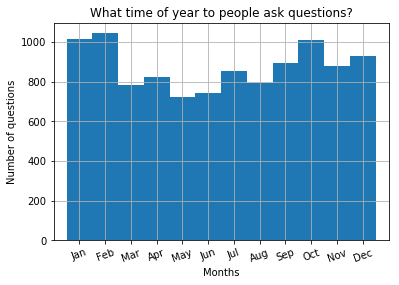

In [39]:
##Create a histogram to show how many questions people ask per month across every year
from matplotlib.pyplot import xticks

df_1.hist(column='Month',bins=np.arange(14)-0.5)

# plt.hist(df_1['Month'],bins=np.arange(14)-0.5)
plt.title('What time of year to people ask questions?')
plt.ylabel('Number of questions')

##replace the tick marks with month names for clarity
locs, labels = xticks()
xticks([1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
      rotation=20)
plt.xlim(0,13)
plt.xlabel('Months')
plt.savefig(directory+'/month_histogram.pdf')

## 1e. What else do you find interesting?

In [40]:
###Lets look at interest in asking questions over the years
##Add another column with just the year
df_1['Year']=df_1.CreationDate.str[0:4].astype(int)

/Users/meshkat/anaconda2/envs/nlp_course/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


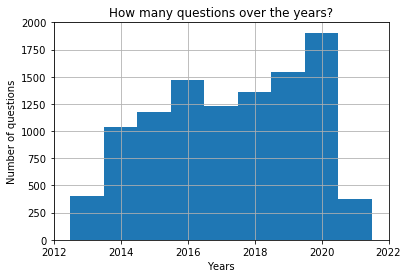

In [41]:
##Create a histogram showing how many questions asked per year?

##determine how many bins to define
num_bins=len(df_1['Year'].unique())

df_1.hist(column='Year', bins=np.arange(11)+2013-0.5)

plt.title('How many questions over the years?')
plt.ylabel('Number of questions')

plt.xlim(2012,2022)
plt.xlabel('Years')
plt.savefig(directory+'/Year_histogram.pdf')

In [42]:
###What is the interest in asking questions about black holes over time?
##make a dataframe with only black hole tags 
df_bh=df_1[df_1['Tags'].astype(str).str.contains("black-hole")]


In [43]:
##Check if black holes were discussed every year
df_bh['Year'].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

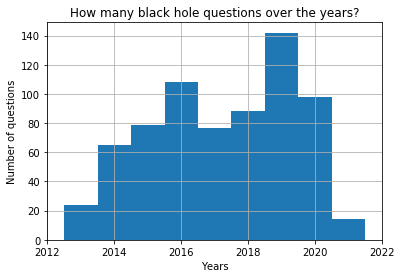

In [44]:
##Create a histogram showing how many questions asked per year that are tagged with black hole

##determine how many bins to define
num_bins=len(df_bh['Year'].unique())

# fig, ax=plt.subplots()
df_bh.hist(column='Year', bins=np.arange(11)+2013-0.5)

plt.title('How many black hole questions over the years?')
plt.ylabel('Number of questions')

plt.xlim(2012,2022)
plt.xlabel('Years')
plt.savefig(directory+'/Year_black-hole_histogram.pdf')

In [45]:
##Clear peak in 2019! Thats when the first image of a black hole was published!

## 2a. What topics are least and most hotly debated? (Feel free to define what you think hotly debated means)

In [46]:
## One way to interpret the most hotly debated topics is to look at answers with the most comments.
## in my experience this can be a gauge for heavilty discussed topics, regardless of how many answers there are
df['AnswerCount']=df['AnswerCount'].astype(int)
df['CommentCount']=df['CommentCount'].astype(int)

df_top_comments=df.sort_values(by=['CommentCount'],ascending=False)[0:50]
df_top_comments

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,Score,ViewCount,Body,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
7353,13531,2,0,1333,2016-02-04T14:51:26.970,5,0,"Old question, but Ill address something that h...",2017-04-13T12:40:15.377,2016-02-04T14:51:26.970,0,0,0,28,0
16239,27916,1,28286,0,2018-10-06T08:37:51.550,2,576,The NPR News item MacArthur Fellow And Planeta...,2020-06-17T09:47:40.653,2020-10-15T07:56:57.047,"What is the nature of ""rock vapor"" in this des...",<the-moon><planetary-formation><formation><col...,2,27,0
8765,16208,2,0,16206,2016-06-12T14:04:43.250,5,0,"First, lets get a bit of background. ""Absolute...",2016-11-21T03:12:29.220,2016-11-21T03:12:29.220,0,0,0,26,0
8784,16235,1,0,0,2016-06-14T13:42:47.100,1,178,I just wanted to double check I had something ...,0,2016-06-22T13:46:01.560,A quick (elementary) check on arsecond convers...,<distances><parallax><parsec>,2,26,0
15407,26910,2,0,26909,2018-07-09T13:34:41.860,40,0,The answer is ironic: Without good instruments...,2020-06-17T09:47:40.653,2019-03-27T11:58:19.650,0,0,0,25,0
6535,12538,2,0,12536,2015-11-18T10:29:47.410,11,0,Rogue planets have been discovered by infra-re...,0,2015-11-18T10:29:47.410,0,0,0,25,0
17157,29069,2,0,29061,2019-01-07T06:34:50.157,9,0,"Yes, there is direct, non-red-shift evidence o...",2019-01-09T04:01:28.507,2019-01-09T04:01:28.507,0,0,0,25,0
8027,14338,2,0,14336,2016-03-28T15:06:49.253,20,0,No. In fact the opposite is the case.(See the ...,2017-09-29T12:10:10.090,2017-09-29T12:10:10.090,0,0,0,24,0
731,796,2,0,782,2013-10-27T03:50:43.473,23,0,"Hot dark matter would be made from very light,...",2013-11-09T12:29:01.997,2013-11-09T12:29:01.997,0,0,0,24,0
19022,32411,2,0,32410,2019-06-25T00:03:54.850,52,0,If the event horizons ever touch and become on...,2019-06-25T19:05:43.203,2019-06-25T19:05:43.203,0,0,0,23,0


In [47]:
## Lets now look at the tags of the text to see common words.


In [48]:
tags_tokens=tokens_list(df_top_comments,'Tags')

In [49]:
Counter(tags_tokens).most_common(10)

[('moon', 3),
 ('formation', 3),
 ('sun', 3),
 ('orbit', 3),
 ('solar', 3),
 ('planetary', 2),
 ('collision', 2),
 ('distances', 2),
 ('sky', 2),
 ('observational', 2)]

In [50]:
## Not as clear how to use this approach with least hotly debated topics as questions with no comments/answers
##don't necessarily imply if it's not "hotly" debated, it's just not been answered.


In [51]:
### Lets do some sentiment analysis
### Lets go through each Body text and rate it as positive, negative, or neutral
### And then see what topics (tagged) are correlated with positive vs negative sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

/Users/meshkat/anaconda2/envs/nlp_course/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [52]:
###Just use the dataframe with tagged data
df_tag=df.loc[df['Tags']!=0]


In [53]:
##Create a function which reads in text and determines if it's positive, 
##negative, or neutral using sid polarity scores (vader)
def neg_pos_neutral(string):
    scores = sid.polarity_scores(string)
    if scores['compound'] == 0:
        return 'Neutral'
    elif scores['compound'] > 0:
        return 'Positive'
    else:
        return 'Negative'

In [54]:
###Create a list with these sentiments
sent=[]
for body in df_tag['Body']:
    sent.append(neg_pos_neutral(body))
        

In [55]:
##Add a column to the dataframe with the sentiment

df_tag['Sentiment']=sent

/Users/meshkat/anaconda2/envs/nlp_course/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
##How many are there in each category
df_tag['Sentiment'].value_counts()

Positive    6554
Negative    2296
Neutral     1640
Name: Sentiment, dtype: int64

In [57]:
### Create two dataframes with just the positive and just the negative. 
df_tag_positive=df_tag.loc[df_tag['Sentiment']=='Positive']
df_tag_negative=df_tag.loc[df_tag['Sentiment']=='Negative']

In [58]:
### For the positives, only use half of them because there are way more positives than negatives
df_tag_positive=df_tag_positive[0:len(df_tag_positive)//2]

In [59]:
###Make sure positives length is halved
len(df_tag_positive)

3277

In [60]:
##Find the most common words in the tags
tag_tokens_pos=tokens_list(df_tag_positive,'Tags')

In [61]:
##what are the 10 most common positive question words
pos=Counter(tag_tokens_pos).most_common(10)

In [62]:
pos

[('star', 446),
 ('astronomy', 344),
 ('telescope', 300),
 ('planet', 269),
 ('solar', 253),
 ('galaxy', 228),
 ('orbit', 218),
 ('black', 218),
 ('hole', 218),
 ('sun', 210)]

In [63]:
pos_words=[x[0] for x in pos]

In [64]:
tag_tokens_neg=tokens_list(df_tag_negative,'Tags')

In [65]:
##What are the 10 most common negative question words
neg=Counter(tag_tokens_neg).most_common(10)

In [66]:
neg

[('star', 349),
 ('black', 238),
 ('hole', 238),
 ('astronomy', 207),
 ('solar', 165),
 ('orbit', 161),
 ('planet', 160),
 ('earth', 148),
 ('sun', 144),
 ('moon', 142)]

In [67]:
neg_words=[x[0] for x in neg]

In [68]:
##Certain words are only associated with positive vs negative
##positive topics: galaxy, telescope
##negative topics: orbit, earth, sun, planet

## 2b. Are you able to classify attributes of questions? For example, can you classify black holes vs planet questions?

In [69]:
## In this case I will try to classify black hole vs planet questions
## Using the tagged data as the training data
## both have approximately the same number of tags (~750)

In [70]:
df['Tags']

0                         <inclination><amateur-observing>
1                                  <exoplanet><atmosphere>
2                         <amateur-observing><binary-star>
3                                      <the-sun><sunspots>
4                                                        0
5                                      <black-hole><light>
6                                                        0
7                     <coordinate><ascension><declination>
8                                                        0
9                                                        0
10                                    <general-relativity>
11                                    <exoplanet><weather>
12                                       <the-moon><orbit>
13                                                       0
14                                                       0
15                                                       0
16                                                      

In [71]:
##The dataframe is 1916 long with approx 750 black hole and 1100 planet

df_pl_bh=df[df['Tags'].astype(str).str.contains("planet|black-hole")]

In [72]:
len(df_pl_bh)

1916

In [73]:
###Create a function to make a list of either planet or black-hole tag to 
##make the machine learning comparison easier
## (necessary because some tags have multiple entries)
def tags_short_list(a_df,column,tag1,tag2):
    tags_list=[]
    for row in a_df[column]:
        if 'planet' in row:
            tags_list.append('planet')
        else:
            tags_list.append('black-hole')
    return tags_list

In [74]:
tags_short_list=tags_short_list(df_pl_bh,'Tags','planet','black-hole')

In [75]:
##Add this list as a new column for easier tagging/identification of attributes
df_pl_bh['TagsShort']=tags_short_list

/Users/meshkat/anaconda2/envs/nlp_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
##Double check it's there
df_pl_bh.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,Score,ViewCount,Body,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,TagsShort
1,2,1,45,0,2013-09-24T18:53:25.647,24,258,How are exoplanetary atmosphere compositional ...,0,2020-12-04T17:02:08.540,How are the compositional components of exopla...,<exoplanet><atmosphere>,1,1,0,planet
5,7,1,8,0,2013-09-24T19:14:05.603,25,5050,Ive heard that light cant escape from a black ...,0,2019-02-16T12:47:55.777,Why can't light escape from a black hole?,<black-hole><light>,3,1,5,black-hole
11,15,1,43,0,2013-09-24T19:30:09.823,17,1193,"On Venus, there is really inhospitable weather...",2013-09-24T19:51:27.420,2014-03-28T19:41:02.037,What is the most extreme weather found on anot...,<exoplanet><weather>,4,1,1,planet
20,24,1,40,0,2013-09-24T19:46:14.980,40,2526,Black holes have so much gravity that even lig...,2017-04-13T12:59:06.910,2015-01-31T01:00:47.090,How are black holes found?,<black-hole>,5,0,9,black-hole
23,27,1,32,0,2013-09-24T19:52:05.020,16,544,"Referring to this question, is there any infor...",2020-09-18T12:38:19.000,2020-09-18T12:38:19.000,Can any information leave a black hole?,<black-hole><universe><hawking-radiation>,1,1,0,black-hole


In [77]:
###Split the data into testing (30% of the data) and training data

from sklearn.model_selection import train_test_split

X = df_pl_bh['Body']
y = df_pl_bh['TagsShort']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


### Build the model, after breaking the data into training/testing. Use Support Vector Machine to create an NLP model. And use the testing data to validate the model

TfidfVectorizer combines CountVectorizer and TfidfTransformer. We already did some preprocessing, but count vectorizer will do it again, including normalization, tokenizing, and filteing out stopwords,etc.

In [78]:
###Vectorize the data and then train and fit a model:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC


# # Linear Support Vector Classification (SVC):
text_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC())])

In [79]:
###Now the training data through the lsvc pipeline
text_lsvc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [80]:
##Run predictions and analyze the results for SVC
predictions = text_lsvc.predict(X_test)

In [81]:
# Confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[171  24]
 [  5 375]]


In [82]:
# Classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

  black-hole       0.97      0.88      0.92       195
      planet       0.94      0.99      0.96       380

   micro avg       0.95      0.95      0.95       575
   macro avg       0.96      0.93      0.94       575
weighted avg       0.95      0.95      0.95       575



In [83]:
# Accuracy
print("The accuracy is ",metrics.accuracy_score(y_test,predictions))

The accuracy is  0.9495652173913044


In [84]:
###Model is 95% accurate at classifying black-hole vs planets

## 2c. What are the most important attributes of questions related to certain types of black-hole/planets? For example, what are some question attributes most relevant to black-holes vs planets?

In [85]:
### Find the most important words used in the fit
### by looking at the coefficients and finding the top features/words

In [86]:
###Print out the top 10 words used in the SVM fit
##Since I used a pipeline, need to use the named_steps to pull out the svc model and the countvectorizer


##How many words we want to return
num_words=10

##Find the words corresponding to each vector
feature_names=text_lsvc.named_steps['tfidf'].get_feature_names()
feature_names = np.array(feature_names)

###The coefficients
coef = text_lsvc.named_steps['clf'].coef_.ravel()

##Find just the most important words for classifying planets vs black holes
top_planet_coefficients = np.argsort(coef)[-num_words:]
top_blackhole_coefficients = np.argsort(coef)[:num_words]

print("Top attributes for planet questions: ",feature_names[top_planet_coefficients])
print("Top attributes for black hole questions: ",feature_names[top_blackhole_coefficients])

Top attributes for planet questions:  ['earths' 'life' 'systems' 'after' 'orbits' 'exoplanet' 'exoplanets'
 'planetary' 'planet' 'planets']
Top attributes for black hole questions:  ['black' 'hole' 'holes' 'neutron' 'event' 'waves' 'horizon' 'massive'
 'ligo' 'mass']


## 2d. Anything else you think would be interesting to explore is encouraged

In [87]:
##Do negative answers get more or fewer comments?

In [88]:
## Already initialized above so don't need to do this again here unless only running this part
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sid = SentimentIntensityAnalyzer()

In [89]:
##Look only at answers now, lets find some examples
df_2=df.loc[df['PostTypeId']==2]

In [90]:
##Determine the sentiment of the answers
sent=[]
for body in df_2['Body']:
    sent.append(neg_pos_neutral(body))
        

In [91]:
##Add the sentiment column
df_2['Sentiment']=sent

/Users/meshkat/anaconda2/envs/nlp_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [92]:
##Create two new dataframes for just the positive and just the negative sentiments

df_2_neg=df_2.loc[df_2['Sentiment']=='Negative']
df_2_pos=df_2.loc[df_2['Sentiment']=='Positive']

In [93]:
##example negative response:
df_2_neg['Body'][65]


'It isnt clear to me if you are merely interested in the equation so that you can plug numbers in and figure it out, or instead would like to understand how the equation is derived. Either way, is called the two-body problem and with that as a search key, it should not be hard to find online references explaining the derivation and illustrating the equation, such as http://en.wikipedia.org/wiki/Gravitational_two-body_problem and http://en.wikipedia.org/wiki/Two-body_problemYou refer to there being two cases, one where A is moving "straightforward" and one where A is orbiting B. This is the same problem, as your first one where A is moving straight forward implies no influence, no gravitational effect from B at all, i.e. it isnt there. If it is there, there is a two-body gravitational effect, which makes it the second case.'

In [94]:
df_2_pos['Body'][4]

'Typical sunspots have a dark region (umbra) surrounded by a lighter region, the penumbra. While sunspots have a temperature of about 6300 °F (3482.2 °C), the surface of the sun which surrounds it has a temperature of 10,000 °F (5537.8 °C).From this NASA resource:  Sunspots are actually regions of the solar surface where the magnetic field of the Sun becomes concentrated over 1000-fold. Scientists do not yet know how this happens. Magnetic fields produce pressure, and this pressure can cause gas inside the sunspot to be in balance with the gas outside the sunspot...but at a lower temperature. Sunspots are actually several thousand degrees cooler than the 5,770 K (5496.8 °C) surface of the Sun, and contain gases at temperature of 3000 to 4000 K (2726.9 - 3726.8 °C). They are dark only by contrast with the much hotter solar surface. If you were to put a sunspot in the night sky, it would glow brighter than the Full Moon with a crimson-orange color!Sunspots are areas of intense magentic a

In [95]:
np.average(df_2_neg['CommentCount'])

1.9236892670875652

In [96]:
np.average(df_2_pos['CommentCount'])

1.8489137914086307

In [97]:
### The difference isn't statistically significant. 
### Also those answers don't look very positive or negative. 

### Perhaps a different/more antagonistic dataset would be more effective 
### Astronomy questions/answers are generally pretty neutral.

## Things you would like to have tried with more time
1. See if questions get more answers/comments if they include a picture (especially on pets.stackexchange.com)
2. Redo my classification predictions for black hole/vs planets but only train the model on the first half of the years (chronologically) and validate it on the later data. More realistic compared to how a model would normally be trained and tested.
3. Clean the urls from the body of the text again (some other url patterns got through)
